In [31]:
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import os
import pandas as pd
import scipy.fft
import scipy.integrate
import shutil

In [32]:
PATH_DATA = r"C:\Users\MIR\Fraunhofer Austria Research GmbH\SMiLe - General\Arbeitspakete\WP2 - Requirements analysis\T2-2 Understand the stakeholders\Use case 2 - Predictive maintenance\Werkzeugdaten"
TMP_PATH = r"C:\Users\MIR\Downloads\tmp"

In [33]:
data_raw = dict()
for bearbeitung in [3, 4, 10, 66, 95]:
    data_raw[bearbeitung] = []
    dirname = f"{PATH_DATA}/Bearbeitung_{bearbeitung:02d}"
    for j, filename in enumerate(sorted(os.listdir(dirname), key=lambda s: s.split("_")[-1]), start=1):
        df = pd.read_csv(f"{dirname}/{filename}")
        data_raw[bearbeitung].append((
            pd.to_datetime(df["TimeStamp"]).to_numpy(),
            df["FastNc_axis_SP1_AxTorqueAct"].to_numpy()
        ))

In [133]:
def moving_average(x, n):
    y = np.zeros(len(x) + 1)
    np.cumsum(x, out=y[1:])
    return (y[n:] - y[:-n]) / n

def ema(x, α):
    m = np.empty_like(x)
    m[0] = 0
    for j in range(1, len(x)):
        m[j] = α * x[j] + (1 - α) * m[j - 1]
    return m

In [135]:
def feature(t, x):
    # return np.sum(np.abs(x))
    return np.max(moving_average(np.abs(x), 100))

[82 95 91 58 89 99 93]


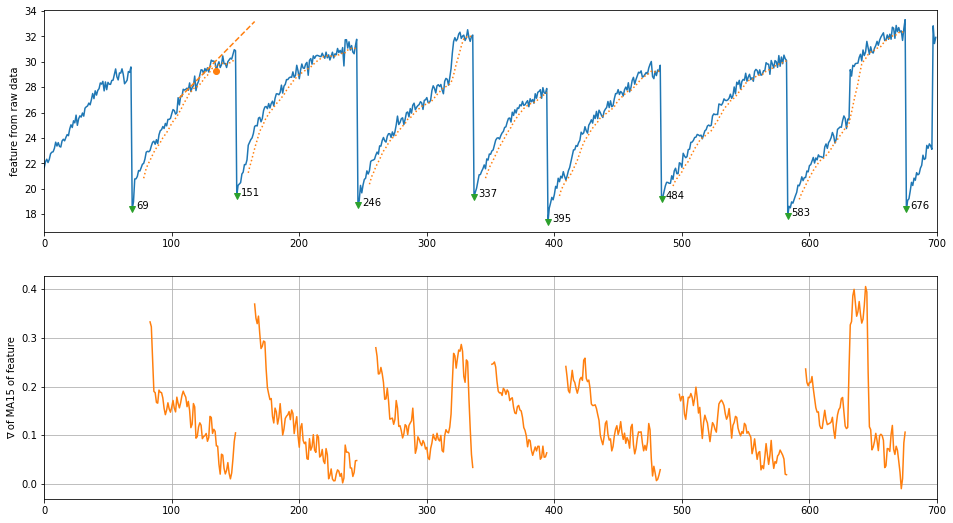

In [139]:
fig, axes = plt.subplots(2, 1, figsize=(16, 9))

ax = axes[0]
#ax = axes

bearbeitung = 10
f = np.asarray([feature(t, x) for t, x in data_raw[bearbeitung]])

grad = np.zeros_like(f)
grad[1:] = f[1:] / f[:-1] - 1

ax.plot(f)

j = 135
ax.plot([j], [f[j]], "o")
n = 30
q = np.polyfit(np.arange(j+1-n, j+1), f[j+1-n:j+1], 1)
x_eval = [j-n+1, j+30]
ax.plot(x_eval, np.polyval(q, x_eval), color="C1", linestyle="--")

j = np.where(grad < -0.2)[0]
print(j[1:] - j[:-1])
ax.plot(j, f[j], "v")
for k in j:
    ax.text(k + 3, f[k], f"{k}")

for k1, k2 in zip(j[:-1], j[1:]):
    ax.plot(np.arange(k1 + 9, k2), moving_average(f[k1:k2], 10), ":", color="C1")

ax.set_xlim(0, 700)
ax.set_ylabel("feature from raw data")

ax = axes[1]
for k1, k2 in zip(j[:-1], j[1:]):
    ma_len = 15
    y = moving_average(f[k1:k2], ma_len)
    #ax.plot(np.arange(k1 + ma_len - 1, k2), y, "-", color="C1")
    ax.plot(np.arange(k1 + ma_len - 1, k2), np.gradient(y), "-", color="C1")
ax.grid(True)
ax.set_xlim(0, 700)
ax.set_ylabel(f"∇ of MA{ma_len} of feature")

plt.show()

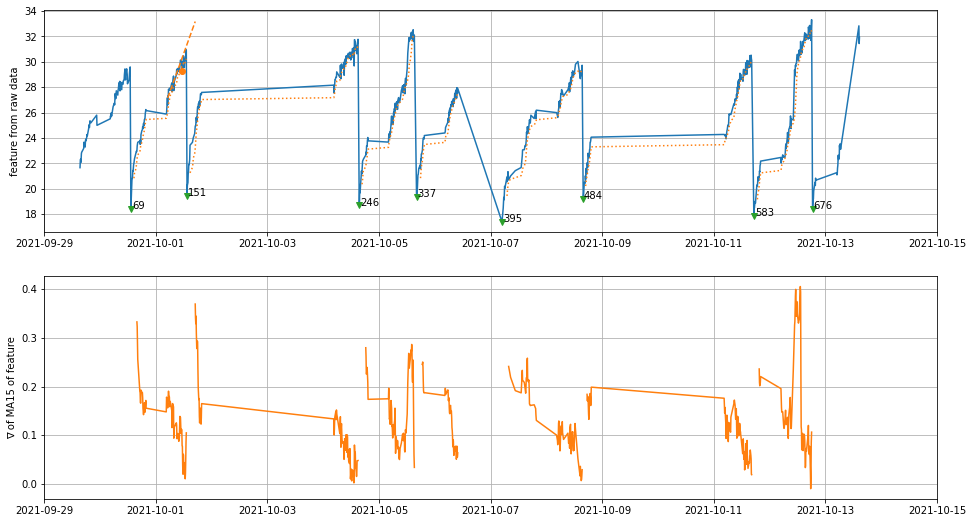

In [37]:
# fig, axes = plt.subplots(1, 1, figsize=(16, 9))
# bearbeitung = 10

# ax = axes
# ax.plot(
#     [t[0] for t, x in data_raw[bearbeitung]],
#     "o"
# )
# ax.grid(True)

fig, axes = plt.subplots(2, 1, figsize=(16, 9))

ax = axes[0]
#ax = axes

bearbeitung = 10
f = np.asarray([feature(t, x) for t, x in data_raw[bearbeitung]])
t_end = np.asarray([t[-1] for t, x in data_raw[bearbeitung]])

grad = np.zeros_like(f)
grad[1:] = f[1:] / f[:-1] - 1

ax.plot(t_end, f)

j = 135
ax.plot([t_end[j]], [f[j]], "o")
n = 30
q = np.polyfit(np.arange(j+1-n, j+1), f[j+1-n:j+1], 1)
x_eval = [j-n+1, j+30]
ax.plot(t_end[x_eval], np.polyval(q, x_eval), color="C1", linestyle="--")

j = np.where(grad < -0.2)[0]
ax.plot(t_end[j], f[j], "v")
for k in j:
    ax.text(t_end[k + 3], f[k], f"{k}")

for k1, k2 in zip(j[:-1], j[1:]):
    ax.plot(t_end[np.arange(k1 + 9, k2)], moving_average(f[k1:k2], 10), ":", color="C1")

ax.grid(True)
ax.set_xlim(pd.to_datetime("2021-09-29"), pd.to_datetime("2021-10-15"))
ax.set_ylabel("feature from raw data")

ax = axes[1]
for k1, k2 in zip(j[:-1], j[1:]):
    ma_len = 15
    y = moving_average(f[k1:k2], ma_len)
    #ax.plot(np.arange(k1 + ma_len - 1, k2), y, "-", color="C1")
    ax.plot(t_end[np.arange(k1 + ma_len - 1, k2)], np.gradient(y), "-", color="C1")

ax.grid(True)
ax.set_xlim(pd.to_datetime("2021-09-29"), pd.to_datetime("2021-10-15"))
ax.set_ylabel(f"∇ of MA{ma_len} of feature")

plt.show()

(8,)
(8,)


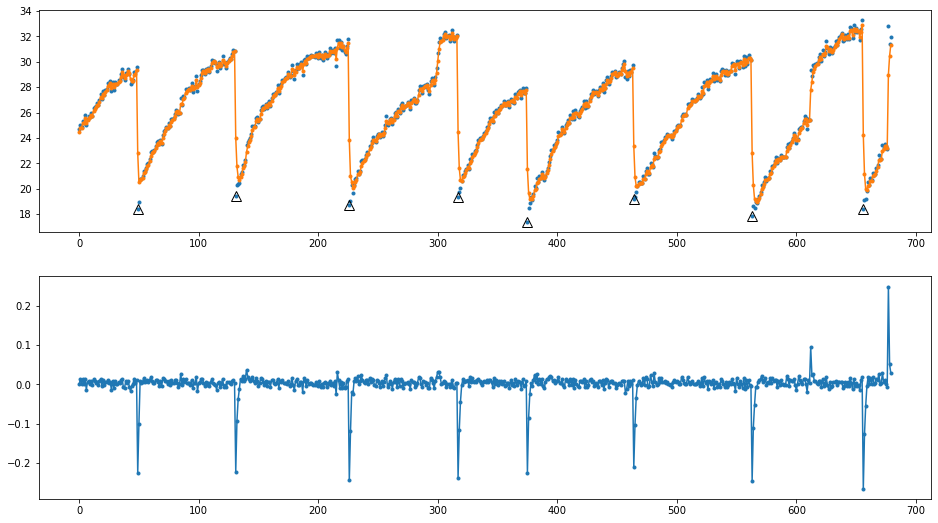

In [161]:
bearbeitung = 10
f = np.asarray([feature(t, x) for t, x in data_raw[bearbeitung]])
f_ema = ema(f, 0.6)
f, f_ema = f[20:], f_ema[20:]
grad = np.zeros_like(f_ema)
grad[1:] = f_ema[1:] / f_ema[:-1] - 1
j = np.where(grad < -0.2)[0]

fig, axes = plt.subplots(2, 1, figsize=(16, 9))

ax = axes[0]
ax.plot(f, ".")
ax.plot(f_ema, ".-")

print(j.shape)
print(f[j].shape)
ax.plot(j, f[j], "^", ms=10, mfc="None", mec="k")

ax = axes[1]
ax.plot(grad, ".-")

plt.show()

In [36]:
class ToolExchangePredictor:
    def __init__(self, history_len: int):
        self._FEATURE_MIN_VALUE = -10000
        self._feature_history = collections.deque(maxlen=history_len)
        self._relative_feature_change_exchange_threshold = -0.2
        self._feature_max_since_previous_exchange = self._FEATURE_MIN_VALUE
        self._feature_exchange_target_value = 0
        self._feature_exchange_target_value_ema_coefficient = 0.7

    def step(self, time: npt.ArrayLike, signal: npt.ArrayLike):
        self._compute_and_append_feature(time, signal)
        self._update_feature_exchange_target_value()
        self._update_feature_prediction()
        return (
            self._feature_history[-1], 
            self._feature_exchange_target_value, 
            self._num_steps_until_next_tool_exchange
        )
    
    def _compute_and_append_feature(self, time: npt.ArrayLike, signal: npt.ArrayLike) -> None:
        self._feature_history.append(self._compute_feature(time, signal))
        
    def _compute_feature(self, time: npt.ArrayLike, signal: npt.ArrayLike) -> float:
        return np.max(moving_average(np.abs(x), 100))
    
    def _update_feature_exchange_target_value(self) -> None:
        if len(self._feature_history) >= 2:
            relative_feature_change = self._feature_history[-1] / self._feature_history[-2] - 1
            tool_exchange_happened = np.heaviside(self._relative_feature_change_exchange_threshold - relative_feature_change, 1)
        else:
            tool_exchange_happened = 0
        
        self._feature_exchange_target_value = (
            tool_exchange_happened * (
                self._feature_exchange_target_value_ema_coefficient * self._feature_max_since_previous_exchange 
                + (1 - self._feature_exchange_target_value_ema_coefficient) * self._feature_exchange_target_value
            )
            + (1 - tool_exchange_happened) * self._feature_exchange_target_value
        )
        self._feature_max_since_previous_exchange = (
            tool_exchange_happened * self._feature_history[-1]
            + (1 - tool_exchange_happened) * max(self._feature_max_since_previous_exchange, self._feature_history[-1])
        )
    
    def _update_feature_prediction(self) -> None:
        x = np.arange(1 - len(self._feature_history), 1)
        assert len(x) == len(self._feature_history)
        assert np.allclose(x[-1], 0)
        x_mean = np.mean(x)
        x_minus_x_mean = x - x_mean
        y = self._feature_history
        y_mean = np.mean(y)
        y_minus_y_mean = y - y_mean
        self._feature_prediction_slope = np.dot(x_minus_x_mean, y_minus_y_mean) / np.dot(x_minus_x_mean, x_minus_x_mean)
        self._feature_prediction_offset = y_mean - self._feature_prediction_slope * x_mean
        self._num_steps_until_next_tool_exchange = (self._feature_exchange_target_value - self._feature_prediction_offset) / self._feature_prediction_slope if self._feature_prediction_slope > 0 else np.nan



C:\Users\MIR\AppData\Local\Temp/ipykernel_14948/816391064.py:54: RuntimeWarning: invalid value encountered in double_scalars
  self._feature_prediction_slope = np.dot(x_minus_x_mean, y_minus_y_mean) / np.dot(x_minus_x_mean, x_minus_x_mean)
C:\Users\MIR\AppData\Local\Temp/ipykernel_14948/3483197766.py:41: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xmin, xmax)
C:\Users\MIR\AppData\Local\Temp/ipykernel_14948/3483197766.py:42: UserWarning: Attempting to set identical bottom == top == 21.657400000000017 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)


KeyboardInterrupt: 

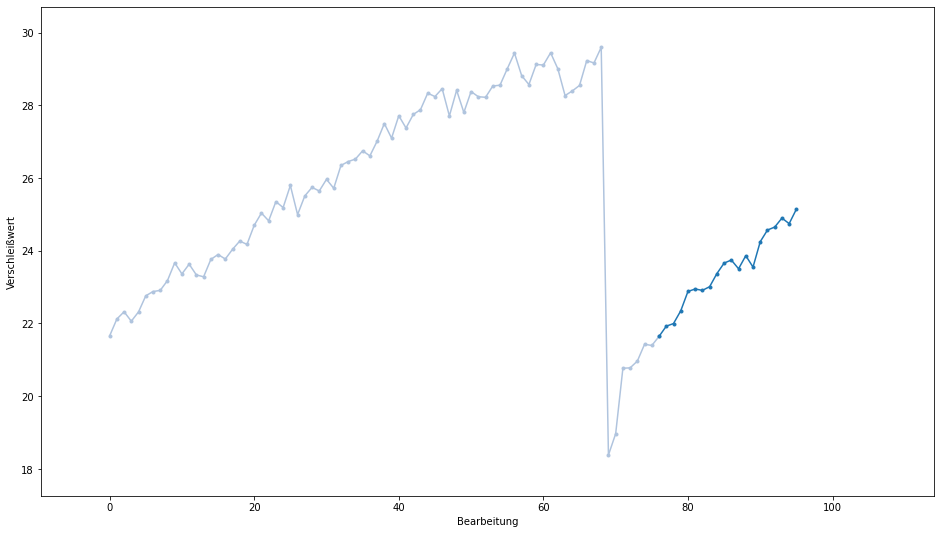

In [40]:
bearbeitung = 10

OUTPUT_DIR = os.path.expanduser("~") + r"\tmp\werkzeugtausch-plots"
if os.path.isdir(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.mkdir(OUTPUT_DIR)

history_len = 30
predictor = ToolExchangePredictor(history_len)
feature_history = []

for j, (t, x) in enumerate(data_raw[bearbeitung], 1):
    feature, feature_exchange_target_value, num_steps_until_next_tool_exchange = predictor.step(t, x)
    feature_history.append(feature)

    fig, ax = plt.subplots(figsize=(16, 9))

    xmin, xmax = 0, len(feature_history) - 1
    tmp = 0.1 * (xmax - xmin)
    xmin -= tmp
    xmax += 2 * tmp

    ymin, ymax = min(feature_history), max(feature_history)
    tmp = 0.1 * (ymax - ymin)
    ymin -= tmp
    ymax += tmp

    if len(feature_history) > history_len:
        ax.plot(feature_history[:-history_len+1], ".-", color="lightsteelblue")
        ax.plot(np.arange(len(feature_history) - history_len, len(feature_history)), feature_history[-history_len:], ".-", color="C0")
    else:
        ax.plot(feature_history, ".-", color="C0")
    
    if j >= 160:
        x_predicted = len(feature_history) - 1 + num_steps_until_next_tool_exchange
        ax.plot([x_predicted] * 2, [ymin, ymax], "--", color="C1")
        x_eval = np.asarray([xmin, xmax])
        ax.plot(x_eval, [feature_exchange_target_value] * 2, "--", color="C1")
        ax.plot(x_eval, predictor._feature_prediction_slope * (x_eval - len(feature_history) + 1) + predictor._feature_prediction_offset, ":", color="C2")
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Bearbeitung")
    ax.set_ylabel("Verschleißwert")
    plt.savefig(f"{OUTPUT_DIR}/{j:04d}.png", dpi=int(1080 / mpl.rcParams["figure.figsize"][1]))
    plt.close()